In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import sys
import os
import time
import numpy as np

import facenet
from draw_boxes import *

#img_path = "../curso_deep_learning_para_multimidia/3_reconhecimento_facial/images/whoever_big.png"
img_path_0 = "../curso_deep_learning_para_multimidia/3_reconhecimento_facial/faces/ney_0.png"
# img_path_1 = "../curso_deep_learning_para_multimidia/3_reconhecimento_facial/faces/ney_1.png"
img_path_nb = "./classification/me_0.png"
img_path_nb2 = "./classification/a_0.png"
thresh = 0.9 #threshold 0 to 1

pile_size = 30 #redundancy

In [2]:
sess = tf.Session()
facenet.load_model("./20170512-110547/20170512-110547.pb")
# facenet.load_model("../curso_deep_learning_para_multimidia/3_reconhecimento_facial/20170512-110547/20170512-110547.pb")

#Selecionando os tensores necessarios para execucao
image_placeholder = tf.get_default_graph().get_tensor_by_name("input:0") 
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0") 
train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")


Model filename: ./20170512-110547/20170512-110547.pb


In [3]:
#Funcao que calcula a distancia euclidiana entre dois vetores
def distance(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2)**2))

def get_embedding(img_path): 
    img_size = 160
    img = cv2.imread(img_path)
    #o opencv abre a imagem em BGR, necessario converter para RGB
    if img is None:
        print("Imagem não pode ser aberta.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Preparando a imagem de entrada
    resized = cv2.resize(img, (img_size,img_size),interpolation=cv2.INTER_CUBIC)
    reshaped = resized.reshape(-1,img_size, img_size,3)
    #Configurando entrada e execucao do FaceNet
    feed_dict = {image_placeholder: reshaped, train_placeholder: False}
    embedding = sess.run(embeddings , feed_dict=feed_dict) 
    return embedding[0], img

def get_embedding_img(img): 
    img_size = 160
    #Preparando a imagem de entrada
    resized = cv2.resize(img, (img_size,img_size),interpolation=cv2.INTER_CUBIC)
    reshaped = resized.reshape(-1,img_size, img_size,3)
    #Configurando entrada e execucao do FaceNet
    feed_dict = {image_placeholder: reshaped, train_placeholder: False}
    embedding = sess.run(embeddings , feed_dict=feed_dict) 
    return embedding[0]

def who_is_it_crop(img, database):
    min_dist = 1000 
    identity = -1
    #Calculando o embedding do visitante
    visitor = get_embedding_img(img)
    #Calculando a distacia do visitante com os demais funcionarios
    res_vec = []
    for name, employee in database.items():
        dist = distance(visitor, employee)
        res_vec.append(dist)
        if dist < min_dist:
            min_dist = dist 
            identity = name
    #verificando a identidade
    if min_dist > 0.5:
        print("Essa pessoa nao esta cadastrada!")
        return None, img, res_vec
    else:
        return identity, img, res_vec
    

In [4]:
def insert_value(pile, value):
    return pile[1:]+[value]

LG - foto cadastrada:


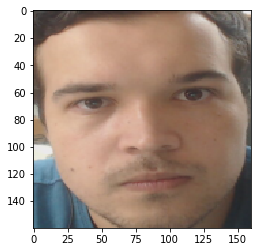

A - foto cadastrada:


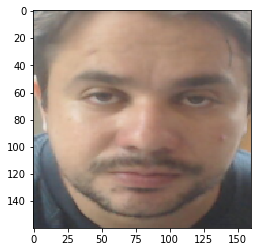

In [5]:
#preparando classificação

database = {}
# database["ney"], img = get_embedding(img_path_0)
# print("ney - foto cadastrada:")
# _ = plt.imshow(img)
# plt.pause(0.1)

database["LG"], img = get_embedding(img_path_nb)
print("LG - foto cadastrada:")
_ = plt.imshow(img)
plt.pause(0.1)

database["A"], img = get_embedding(img_path_nb2)
print("A - foto cadastrada:")
_ = plt.imshow(img)
plt.pause(0.1)

avg = {}
avg["LG"] = [0 for v in range(pile_size)]
avg["A"] = [0 for v in range(pile_size)]

In [6]:
cap = cv2.VideoCapture(0)

cv2.namedWindow("window", cv2.WND_PROP_FULLSCREEN)
cv2.setWindowProperty("window", cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)

In [7]:
##CRAZY NAMES##

from faced import FaceDetector #for better cpu support
from faced.utils import annotate_image

face_detector = FaceDetector()

while cap.isOpened():
    now = time.time()
    # Capture frame-by-frame
    ret, frame = cap.read()

    if frame.shape[0] == 0:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if thresh:
        bboxes = face_detector.predict(rgb_frame, thresh)
    else:
        bboxes = face_detector.predict(rgb_frame)
    
    if len(bboxes) != 0:
        results = []
        for x,y,w,h,p in bboxes :
            ####
            x0=int(x-w/2)
            y0=int(y-h/2)
            x0plusw = int(x+w/2)
            y0plush = int(y+h/2)
            ####
            identity, image, out_vect = who_is_it_crop(rgb_frame[y0: y0plush,x0 : x0plusw], database)
            avg["A"] = insert_value(avg["A"], out_vect[0])
            avg["LG"] = insert_value(avg["LG"], out_vect[1])
            resA = sum(avg["A"])/len(avg["A"])
            resLG = sum(avg["LG"])/len(avg["LG"])
            #results.append((x,y,w,h,p,identity))
            results.append((x,y,w,h,p,str(resA-resLG)))
        ann_frame = boxing(frame,results)
    else:
        ann_frame = frame
    
    #ann_frame = annotate_image(frame, bboxes)
    cv2.imshow('window', ann_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

#####################FROM PIC#####################

# img = cv2.imread(img_path_1)
# rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

# # Receives RGB numpy image (HxWxC) and
# # returns (x_center, y_center, width, height, prob) tuples. 
# bboxes = face_detector.predict(rgb_img, thresh)

# # Use this utils function to annotate the image.
# # ann_img = annotate_image(rgb_img, bboxes)

# # Show the image
# #cv2.imshow('image',ann_img)
# #cv2.waitKey(0)
# #cv2.destroyAllWindows()

# crops = []
# for x,y,w,h,p in bboxes :
#     x0=int(x-w)#/2)
#     y0=int(y-h)#/2)
#     x0plusw = int(x+w)#/2)
#     y0plush = int(y+h)#/2)
#     crops.append(rgb_img[y0: y0plush,x0 : x0plusw])
# #     crops.append(rgb_img[y: h,x : w])

# _ = plt.imshow(ann_img)
# plt.pause(0.1)


Essa pessoa nao esta cadastrada!


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# for obj in crops :
#     identity, image = who_is_it_crop(obj, database)
#     print("Essa pessoa é o(a)",identity,"!")
#     _ = plt.imshow(image)
#     plt.pause(0.1)

In [ ]:
# from faced import FaceDetector #for better cpu support
# from faced.utils import annotate_image

# face_detector = FaceDetector()

# past = time.time()

# while cap.isOpened():
#     now = time.time()
#     # Capture frame-by-frame
    
#     if (time-past) > 60:
#         #...
    
#     ret, frame = cap.read()

#     if frame.shape[0] == 0:
#         break

#     rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     if thresh:
#         bboxes = face_detector.predict(rgb_frame, thresh)
#     else:
#         bboxes = face_detector.predict(rgb_frame)
    
#     if len(bboxes) != 0:
#         results = []
#         for x,y,w,h,p in bboxes :
#             ####
#             x0=int(x-w/2)
#             y0=int(y-h/2)
#             x0plusw = int(x+w/2)
#             y0plush = int(y+h/2)
#             ####
#             identity, image = who_is_it_crop(rgb_frame[y0: y0plush,x0 : x0plusw], database)
#             results.append((x,y,w,h,p,identity))
#         ann_frame = boxing(frame,results)
#     else:
#         ann_frame = frame
    
#     #ann_frame = annotate_image(frame, bboxes)
#     cv2.imshow('window', ann_frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()